In [1]:
import numpy as np
import pandas as pd
import time

import random

import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

#import pickle5 as pickle

from IPython import display
%matplotlib inline

import matplotlib.ticker as tick

import sys
sys.path.append('..')
from nsgp_vi import nsgpVI


# We'll use double precision throughout for better numerics.
dtype = np.float64


tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 
#v3 i.e. version 3, given by the new way(third way) of calculating the batches

In [6]:
df = pd.read_csv('../data/ns_synthetic_data_indv_1.csv')
T = df['Time'].values[:,None]
ID = df['ID'].values
X = np.array(df['observations']).reshape(len(T),1)
true_len = np.array(df['Lengthscale']).reshape(len(T),1)
true_var = np.array(df['Variance']).reshape(len(T),1)

In [7]:
num_training_points_ = T.shape[0]
num_inducing_points_ = 50
inducing_index_points = np.linspace(0., 60*24., num_inducing_points_, endpoint=False)[..., np.newaxis]
np.random.shuffle(inducing_index_points)


In [11]:
# create the dataset

BATCH_SIZE=8
SEG_LENGTH=1024

allT = []
allX = []
for i in np.unique(df['ID'].values):
    allT.append(df['Time'][df['ID'].values == i].values[...,None])
    allX.append(df['observations'][df['ID'].values == i].values[...,None])

class segment_generator:
    def __iter__(self):
        
        # loop over individuals
        self.i = 0
        self.max_i = len(allT)
        
        # loop over segments
        self.j = 0
        self.max_j = num_training_points_//(self.max_i*SEG_LENGTH)
        
        
        
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            self.i = 0
            self.j +=1
            if self.j==self.max_j:
                raise StopIteration
            
        T = allT[self.i]
        X = allX[self.i] 

        

        TT = T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
    
        self.i += 1

        return TT,XX

        
dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64)) 
dataset = dataset.map(lambda dd: (dd[0],dd[1]))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE)
d_size = T.shape[0]//SEG_LENGTH//(BATCH_SIZE)

In [12]:

for d in dataset:
    print(d[0].shape)


(8, 1024, 1)


In [13]:
## set up the kernels and model

kernel_len_a = tfp.util.TransformedVariable(2.0, tfb.Softplus(),dtype=tf.float64, name='k_len_a',trainable=True)
kernel_len_l = tfp.util.TransformedVariable(30.0,tfb.Chain([tfb.Scale(np.float64(60.)),tfb.Softplus()]),dtype=tf.float64, name='k_len_l',trainable=True)

# amplitude kernel parameters, lower levels
kernel_amp_a = tfp.util.TransformedVariable(2.0, tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=True)
kernel_amp_l = tfp.util.TransformedVariable(30.0,tfb.Chain([tfb.Scale(np.float64(60.)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=True)

    #kernels on the second layer
kernel_len = tfk.ExponentiatedQuadratic(kernel_len_a,kernel_len_l)
kernel_amp = tfk.ExponentiatedQuadratic(kernel_amp_a,kernel_amp_l)

vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,inducing_index_points=inducing_index_points,dataset=dataset,num_training_points=num_training_points_, num_sequential_samples=10,num_parallel_samples=10,init_observation_noise_variance=0.005**2)  


In [1]:

# optimize the model
loss = vgp.optimize(BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=500)


In [ ]:
plt.plot(loss[:])
plt.show()

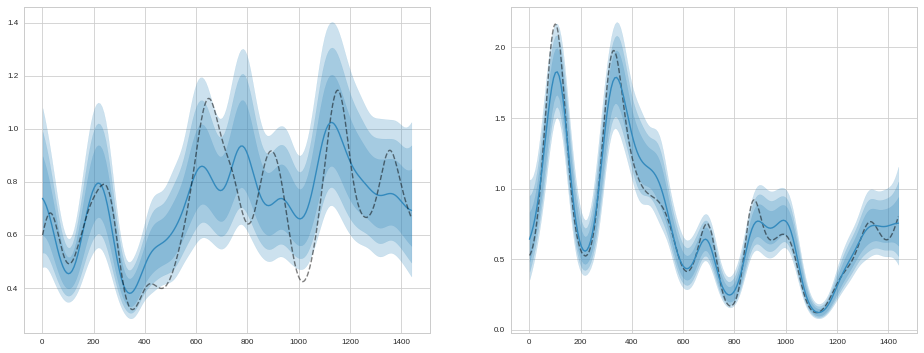

In [18]:

ZZ = np.linspace(0,24*60,200)[:,None]

len_mean, len_var = vgp.get_len_cond(ZZ[None,...],full_cov=False)
len_mean = len_mean[0,:,0].numpy()
len_std = len_var[:,0].numpy()**0.5



amp_mean, amp_var = vgp.get_amp_cond(ZZ[None,...],full_cov=False)
amp_mean = amp_mean[0,:,0].numpy()
amp_std = amp_var[:,0].numpy()**0.5


# for i in range(S):
#     plt.plot(ZZ,len_vals[i],color='C0',alpha=0.01)
# #plt.plot(T,true_len,'.',markersize=1,color='blue')
# plt.plot(vgp.len_inducing_index_points.numpy(), np.ones_like(vgp.len_inducing_index_points.numpy()),'o')


f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))


ax1.plot(ZZ,tf.math.softplus(vgp.mean_len + len_mean),color='C1')

ax1.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_len + len_mean - 1.28*len_std),tf.math.softplus(vgp.mean_len + len_mean + 1.28*len_std),color='C1',alpha=0.25)
ax1.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_len + len_mean - 1.96*len_std),tf.math.softplus(vgp.mean_len + len_mean + 1.96*len_std),color='C1',alpha=0.25)
ax1.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_len + len_mean - 2.58*len_std),tf.math.softplus(vgp.mean_len + len_mean + 2.58*len_std),color='C1',alpha=0.25)
#ax1.plot(T,true_len,'.',markersize=1,color='red')
ax1.plot(T[:8192],true_len[:8192],'--',markersize=1,color='k',alpha=0.5)


ax2.plot(T[:8192],true_var[:8192],'--',markersize=1,color='k',alpha=0.5)
ax2.plot(ZZ,tf.math.softplus(vgp.mean_amp + amp_mean),color='C1')

ax2.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_amp + amp_mean - 1.28*amp_std),tf.math.softplus(vgp.mean_amp + amp_mean + 1.28*amp_std),color='C1',alpha=0.25)
ax2.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_amp + amp_mean - 1.96*amp_std),tf.math.softplus(vgp.mean_amp + amp_mean + 1.96*amp_std),color='C1',alpha=0.25)
ax2.fill_between(ZZ[:,0],tf.math.softplus(vgp.mean_amp + amp_mean - 2.58*amp_std),tf.math.softplus(vgp.mean_amp + amp_mean + 2.58*amp_std),color='C1',alpha=0.25)

plt.show()
# plt.plot(ZZ,tf.math.softplus(vgp.mean_amp + amp_mean[0]+amp_var[:,0]**0.5),co

In [ ]:

S=1000
ZZ = np.linspace(0,24*60,200)[:,None]
ZZ.shape
len_vals = tf.squeeze(vgp.get_len_samples(ZZ[None,...],S))
amp_vals = tf.squeeze(vgp.get_amp_samples(ZZ[None,...],S))


for i in range(S):
    plt.plot(ZZ,len_vals[i],color='C0',alpha=0.01)
plt.plot(T,true_len,'.',markersize=1,color='blue')

plt.show()

for i in range(S):
    plt.plot(ZZ,amp_vals[i],color='C0',alpha=0.01)
plt.plot(T,true_var,'.',markersize=1,color='blue')

plt.show()